<a href="https://colab.research.google.com/github/1richi1/3D_Object_Recognition_DLNN/blob/main/ORION_ARCH_final_version_per_32x32x32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AURORA**
### *AUgmented Recognition ORientation-boosted Architecture*

---
##### Giovanni Girardin, Alberto Morselli, Riccardo Rettore 2110512
---


In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import h5py

**General info:**

The augmented dataset is available at the following link: https://drive.google.com/file/d/1bRfeHYS-KcZ7qOQJoFgPBPendgOYzM2K/view?usp=drive_link

The .pth checkpoint files used are available here: https://drive.google.com/drive/folders/1gOYiUpHhEE818x179wKjCSI7Q5iZOLPg?usp=drive_link

To run the following cells, be sure to have in your "My drive" section the dataset_40_32.h5 file and to create a pth_results folder with all the .pth files inside.

## HDF5 AUGMENTED DATASET




In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

save_path = "/content/drive/My Drive/pth_results/"

if not os.path.exists(save_path):
    # Create the folder
    os.makedirs(save_path)
    print(f"Folder '{save_path}' created successfully.")

hdf5_file_path = "/content/drive/My Drive/dataset_40_32.h5"
ORIENT_LABELS = 18
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

Mounted at /content/drive
cuda


### Dataloader

In [ ]:
class VoxelDatasetHDF5(Dataset):
    def __init__(self, hdf5_file, train=True, transform=None):
        self.hdf5_file = hdf5_file
        self.train = train
        self.transform = transform

        # Open the HDF5 file
        with h5py.File(self.hdf5_file, 'r') as f:
            # Get class names from the structure of the HDF5 file
            self.classes = sorted(list(f['classes'].keys()))

            # Collect all paths (keys) to the datasets inside HDF5
            self.file_paths = []
            for class_name in self.classes:
                folder = 'train' if train else 'test'
                class_group = f['classes'][class_name][folder]
                self.file_paths += [(class_name, folder, file_name) for file_name in class_group.keys()]

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        class_name, folder, file_name = self.file_paths[idx]

        # Detect corrupted files based on the presence of "(1)" in the file name
        if "(1)" in file_name:
            print(f"Corrupted file detected and skipped: {file_name}")
            return None  # Skip this file

        # Load voxelized numpy array from the HDF5 file
        with h5py.File(self.hdf5_file, 'r') as f:
            voxel_data = f['classes'][class_name][folder][file_name][()]

        # Add a channel dimension: Shape (1, 33, 33, 33)
        voxel_data = np.expand_dims(voxel_data, axis=0)

        if self.transform:
            voxel_data = self.transform(voxel_data)

        voxel_data = torch.tensor(voxel_data, dtype=torch.float32)

        # Get class label
        class_label = self.classes.index(class_name)

        # Extract the orientation from the file name and convert to a bin index based on the number of bins for this class
        try:
            orientation_number = int(file_name.split('_')[-1].split('.')[0])
        except:
            orientation_number = 17  # Handle error case
            print(f"Error parsing orientation for file: {file_name}")

        orientation_label = torch.tensor(orientation_number, dtype=torch.long)

        return voxel_data, class_label, orientation_label

## ARCHITECTURE

In [ ]:
class ImprovedORION(nn.Module):
    def __init__(self, num_class=40, num_orient=105):
        super().__init__()

        self.conv_net = nn.Sequential(
            #conv1
            nn.Conv3d(1,32,3,stride=2,padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.1,True),
            nn.Dropout3d(0.2),

            #conv2
            nn.Conv3d(32,64,3,1,1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.1,True),
            nn.Dropout3d(0.3),

            #conv3
            nn.Conv3d(64,128,3,1,0),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.1,True),
            #pool3
            nn.MaxPool3d(2,2),
            nn.Dropout3d(0.4),

            #conv4
            nn.Conv3d(128,256,3,1,0),
            nn.BatchNorm3d(256),
            nn.LeakyReLU(0.1,True),
            #pool4
            nn.MaxPool3d(2,2),
            nn.Dropout3d(0.6),
        )

        self.flatten = nn.Flatten()

        self.fc_net = nn.Sequential(
            nn.Linear(256*2**3, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Linear(256, num_class + num_orient),
        )
        # Initialize the weights
        self.num_class = num_class
        self.num_orient = num_orient

    def forward(self, x):
        x = self.conv_net(x)
        x = self.flatten(x)
        x = self.fc_net(x)

        # Split the output into class and orientation
        class_output = x[:, :self.num_class]  # First part for class
        orient_output = x[:, self.num_class:]  # Remaining part for orientation
        return class_output, orient_output

class CustomCrossEntropyLoss(nn.Module):
    def __init__(self, neurons_per_class):
        super(CustomCrossEntropyLoss, self).__init__()
        self.neurons_per_class = neurons_per_class

        self.incremental = np.cumsum(self.neurons_per_class)
        self.incremental = np.insert(self.incremental, 0, 0)
        self.incremental = self.incremental[:-1]

        self.scaling_factor = np.array([ ORIENT_LABELS // self.neurons_per_class[i] for i in range(len(self.neurons_per_class))])
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, class_neurons, orient_neurons, class_labels, orient_labels):
        remapped_labels = torch.zeros_like(orient_labels)
        for i in range(orient_labels.shape[0]):
            remapped_labels[i] = self.incremental[class_labels[i]] + orient_labels[i] // self.scaling_factor[class_labels[i]]

        class_loss = self.cross_entropy(class_neurons, class_labels)
        orient_loss = self.cross_entropy(orient_neurons, remapped_labels)

        return class_loss, orient_loss

## TRAINING & VALIDATION

In [ ]:
def train_and_val_model(model, train_loader, criterion, optimizer, start_epoch=0, num_epochs=10, device=device, gamma=0.5):
    model.to(device)

    #dont train the loss
    for param in criterion.parameters():
          param.requires_grad = False

    for epoch in range(start_epoch, num_epochs):

        #training step
        print("TRAINING Epoch #",epoch)
        model.train()
        running_loss = 0.0

        # Loop over the dataset
        for voxel_data, class_labels, orientation_labels in tqdm(train_loader):
            # Move data to the device
            voxel_data = voxel_data.to(device)
            class_labels = class_labels.to(device)
            orientation_labels = orientation_labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            class_outputs, orient_outputs = model(voxel_data)

            # Compute loss
            class_loss, orient_loss = criterion(class_outputs, orient_outputs, class_labels, orientation_labels)
            loss = gamma * class_loss + (1-gamma) * orient_loss

            # Backpropagation and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            print(f'Batch Loss: {loss.item():.4f}')

        # Print statistics at the end of every training epoch
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')
        save_model(epoch, model, optimizer, loss.item(), f"{save_path}model_ORION_0.5_per32x32x32_epoch_{epoch}_batchsize_{batch_size}_numw{num_workers}.pth")

        #validation step
        print("VALIDATION Epoch #",epoch)
        model.eval()
        valid_loss = 0.0
        correct_class = 0
        correct_orient = 0
        total_samples = 0

        with torch.no_grad():
            for voxel_data, class_labels, orientation_labels in tqdm(test_loader):
                voxel_data = voxel_data.to(device)
                class_labels = class_labels.to(device)
                orientation_labels = orientation_labels.to(device)

                class_outputs, orient_outputs = model(voxel_data)

                class_loss, orient_loss = criterion(class_outputs, orient_outputs, class_labels, orientation_labels)
                total_loss = gamma * class_loss + (1-gamma) * orient_loss

                valid_loss += total_loss.item()

                #extract the one with highest prob
                _, predicted_class = torch.max(class_outputs, 1)

                total_samples += class_labels.size(0)
                correct_class += (class_labels == predicted_class).sum().item()

                #remap the labels before performing the accuracy metric with orientations
                remapped_labels = torch.zeros_like(orientation_labels)
                predicted_orient = [[] for _ in range(orientation_labels.shape[0])]
                for i in range(orientation_labels.shape[0]):
                    remapped_labels[i] = criterion.incremental[class_labels[i]] + orientation_labels[i] // criterion.scaling_factor[class_labels[i]]
                    metric = max(1, criterion.neurons_per_class[class_labels[i]]//3)
                    _, predicted_orient[i] = torch.topk(orient_outputs[i], metric) #top-1/2/3

                    if remapped_labels[i] in predicted_orient[i]:
                        correct_orient += 1

                print(f'correct_class: {correct_class}/{total_samples} correct_orient: {correct_orient}/{total_samples}')

        class_accuracy = correct_class / total_samples
        orient_accuracy = correct_orient / total_samples

        print(f'Class Accuracy: {class_accuracy:.4f}')
        print(f'Orientation Accuracy: {orient_accuracy:.4f}')

In [ ]:
def save_model(epoch, model, optimizer, loss, save_path=save_path):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, save_path)
    print(f"Model saved to {save_path}")

def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model and optimizer state dicts
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    epoch = checkpoint['epoch'] +1
    loss = checkpoint['loss']

    print(f"Checkpoint loaded model from epoch {epoch-1} with loss {loss}. Resuming next with epoch {epoch}")

    return model, optimizer, epoch, loss

In [ ]:
num_workers = 0
batch_size = 64
train_dataset = VoxelDatasetHDF5(hdf5_file=hdf5_file_path, train=True)
test_dataset = VoxelDatasetHDF5(hdf5_file=hdf5_file_path, train=False)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
#ModelNet10
#neurons_per_class = np.array([6, 3, 6, 6, 6, 9, 3, 6, 1, 9])
#ModelNet40
neurons_per_class = np.array([6, 6, 1, 6, 6, 1, 1, 3, 6, 1, 3, 9, 6, 6, 6, 3, 3, 9, 1, 3, 6, 6, 9, 3, 6, 9, 6, 3, 6, 6, 6, 9, 3, 1, 3, 6, 3, 1, 6, 6])

# Initialize the model, loss function, and optimizer
num_class = len(neurons_per_class)
num_orient = neurons_per_class.sum()


In [ ]:
model = ImprovedORION(num_class=num_class, num_orient=num_orient)
criterion = CustomCrossEntropyLoss(neurons_per_class=neurons_per_class)
optimizer = optim.Adam(model.parameters(), lr=0.001)
start_epoch = 0

#model, optimizer, start_epoch, last_loss = load_checkpoint(model, optimizer, save_path+"model_ORION_0.5_per32x32x32_epoch_9_batchsize_64_numw0.pth", device)

# Make sure to move optimizer's internal state to the correct device
if(start_epoch > 0):
    for state in optimizer.state.values():
        for k, v in state.items():
            if isinstance(v, torch.Tensor):
                state[k] = v.to(device)

train_and_val_model(model, train_loader, criterion, optimizer, start_epoch, num_epochs=10, device=device, gamma=0.5)


<ipython-input-13-c76edbf797f0>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Checkpoint loaded model from epoch 9 with loss 0.9442210793495178. Resuming next with epoch 10


##VALIDATION PLOTS

<ipython-input-23-340a43e44c03>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
100%|██████████| 43566/43566 

Epoch 1/9 - Validation Loss: 1.0938, Class Accuracy: 0.8365, Orientation Accuracy: 0.5965


100%|██████████| 43566/43566 [05:50<00:00, 124.30it/s]


Epoch 2/9 - Validation Loss: 0.9901, Class Accuracy: 0.8620, Orientation Accuracy: 0.6216


100%|██████████| 43566/43566 [05:35<00:00, 129.70it/s]


Epoch 3/9 - Validation Loss: 0.9666, Class Accuracy: 0.8578, Orientation Accuracy: 0.6310


100%|██████████| 43566/43566 [05:29<00:00, 132.05it/s]


Epoch 4/9 - Validation Loss: 0.9343, Class Accuracy: 0.8729, Orientation Accuracy: 0.6440


100%|██████████| 43566/43566 [05:30<00:00, 131.79it/s]


Epoch 5/9 - Validation Loss: 0.9339, Class Accuracy: 0.8733, Orientation Accuracy: 0.6447


100%|██████████| 43566/43566 [05:28<00:00, 132.65it/s]


Epoch 6/9 - Validation Loss: 0.9352, Class Accuracy: 0.8735, Orientation Accuracy: 0.6448


100%|██████████| 43566/43566 [05:29<00:00, 132.35it/s]


Epoch 7/9 - Validation Loss: 0.9196, Class Accuracy: 0.8794, Orientation Accuracy: 0.6506


100%|██████████| 43566/43566 [05:42<00:00, 127.13it/s]


Epoch 8/9 - Validation Loss: 0.9140, Class Accuracy: 0.8783, Orientation Accuracy: 0.6559


100%|██████████| 43566/43566 [05:45<00:00, 126.08it/s]


Epoch 9/9 - Validation Loss: 0.9158, Class Accuracy: 0.8792, Orientation Accuracy: 0.6550


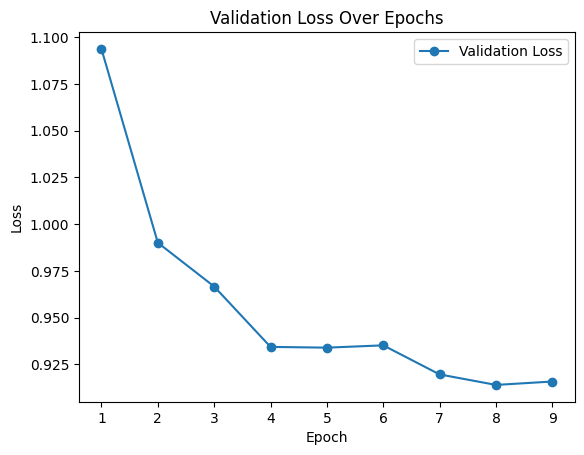

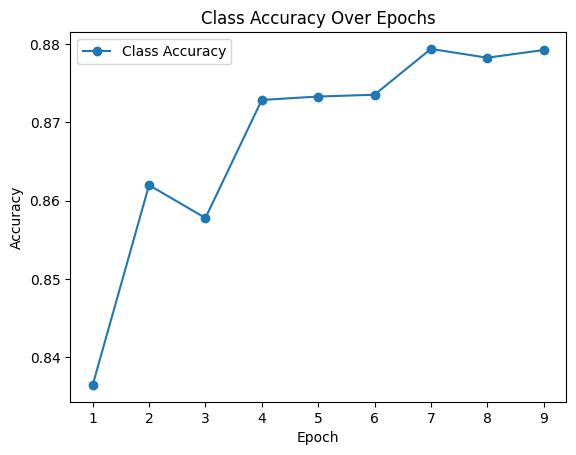

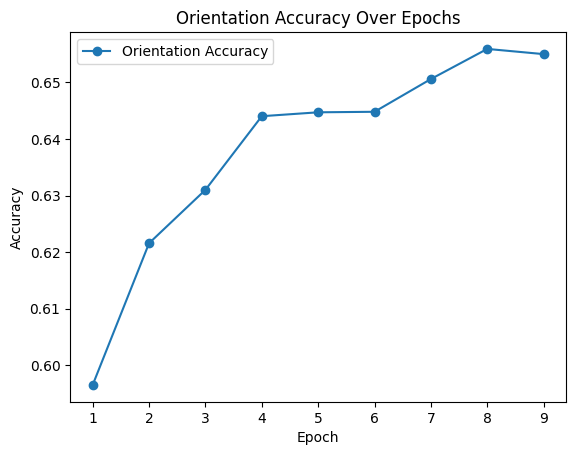

In [ ]:
num_epochs = 9  # Adjust this based on the number of checkpoints
gamma = 0.5  # Replace with your actual gamma value
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Lists to store the losses and accuracies for each epoch
validation_losses = []
class_accuracies = []
orient_accuracies = []

# Validation step for each checkpoint
for epoch in range(num_epochs):
    checkpoint_path = save_path+f"model_ORION_0.5_per32x32x32_epoch_{epoch}_batchsize_64_numw0.pth"
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # Perform validation
    model.eval()
    valid_loss = 0.0
    correct_class = 0
    correct_orient = 0
    total_samples = 0

    with torch.no_grad():
        for voxel_data, class_labels, orientation_labels in tqdm(test_loader):
            voxel_data = voxel_data.to(device)
            class_labels = class_labels.to(device)
            orientation_labels = orientation_labels.to(device)

            # Forward pass
            class_outputs, orient_outputs = model(voxel_data)

            # Compute loss
            class_loss, orient_loss = criterion(class_outputs, orient_outputs, class_labels, orientation_labels)
            total_loss = gamma * class_loss + (1 - gamma) * orient_loss
            valid_loss += total_loss.item()

            # Accuracy for classes
            _, predicted_class = torch.max(class_outputs, 1)
            total_samples += class_labels.size(0)
            correct_class += (class_labels == predicted_class).sum().item()

            # Orientation accuracy
            remapped_labels = torch.zeros_like(orientation_labels)
            predicted_orient = [[] for _ in range(orientation_labels.shape[0])]
            for i in range(orientation_labels.shape[0]):
                remapped_labels[i] = criterion.incremental[class_labels[i]] + orientation_labels[i] // criterion.scaling_factor[class_labels[i]]
                metric = max(1, criterion.neurons_per_class[class_labels[i]] // 3)
                _, predicted_orient[i] = torch.topk(orient_outputs[i], metric)

                if remapped_labels[i] in predicted_orient[i]:
                    correct_orient += 1

    # Calculate average loss and accuracy for this epoch
    avg_valid_loss = valid_loss / len(test_loader)
    class_accuracy = correct_class / total_samples
    orient_accuracy = correct_orient / total_samples

    # Store results for plotting
    validation_losses.append(avg_valid_loss)
    class_accuracies.append(class_accuracy)
    orient_accuracies.append(orient_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs} - Validation Loss: {avg_valid_loss:.4f}, "
          f"Class Accuracy: {class_accuracy:.4f}, Orientation Accuracy: {orient_accuracy:.4f}")

# Plot validation loss
plt.figure()
plt.plot(range(1, num_epochs + 1), validation_losses, marker='o', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Over Epochs")
plt.legend()
plt.show()

# Plot class accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), class_accuracies, marker='o', label="Class Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Class Accuracy Over Epochs")
plt.legend()
plt.show()

# Plot orientation accuracy
plt.figure()
plt.plot(range(1, num_epochs + 1), orient_accuracies, marker='o', label="Orientation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Orientation Accuracy Over Epochs")
plt.legend()
plt.show()
